In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, dilation=dilation, bias=True)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-5)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride=1, downsample=False):
        super().__init__()
        self.conv1 = ConvBNReLU(in_channels, mid_channels, kernel_size=3, stride=stride, padding=1)
        self.conv2 = ConvBNReLU(mid_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = ConvBNReLU(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            identity = self.downsample(x)
        return F.relu(out + identity)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = ConvBNReLU(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.branch2 = ConvBNReLU(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
        self.branch3 = ConvBNReLU(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12)
        self.branch4 = ConvBNReLU(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18)

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        return torch.cat([out1, out2, out3, out4], dim=1)

class CNN_C52v(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            ConvBNReLU(3, 64, 7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 1/4
        )

        # Residual blocks (downsample progressively)
        self.res2a = ResidualBlock(64, 64, 64)
        self.res2b = ResidualBlock(64, 64, 64)
        self.res3a = ResidualBlock(64, 64, 128, stride=2, downsample=True)  # 1/8
        self.res3b = ResidualBlock(128, 128, 128)
        self.res4a = ResidualBlock(128, 128, 256, stride=2, downsample=True)  # 1/16
        self.res4b = ResidualBlock(256, 256, 256)
        self.res5a = ResidualBlock(256, 256, 512, stride=1, downsample=True)
        self.res5b = ResidualBlock(512, 512, 512)

        # ASPP
        self.aspp = ASPP(512, 256)

        # Projection after ASPP
        self.projection = nn.Sequential(
            nn.Conv2d(1024, 256, 1),  # ASPP output channels = 4 * 256 = 1024
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Decoder to restore original size (using ConvTranspose2d)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1/16 → 1/8
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 1/8 → 1/4
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 1/4 → 1/2
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1)      # 1/2 → full resolution
        )

    def forward(self, x):
        x = self.stem(x)       # -> 1/4
        x = self.res2a(x)
        x = self.res2b(x)
        x = self.res3a(x)      # -> 1/8
        x = self.res3b(x)
        x = self.res4a(x)      # -> 1/16
        x = self.res4b(x)
        x = self.res5a(x)
        x = self.res5b(x)

        x = self.aspp(x)
        x = self.projection(x)
        x = self.decoder(x)    # -> back to input resolution
        return x

# Example usage
model = CNN_C52v()
x = torch.randn(1, 3, 256, 1024)
out = model(x)
print("Output shape:", out.shape)  # Expected: (1, 2, 256, 1024)

Output shape: torch.Size([1, 2, 256, 1024])


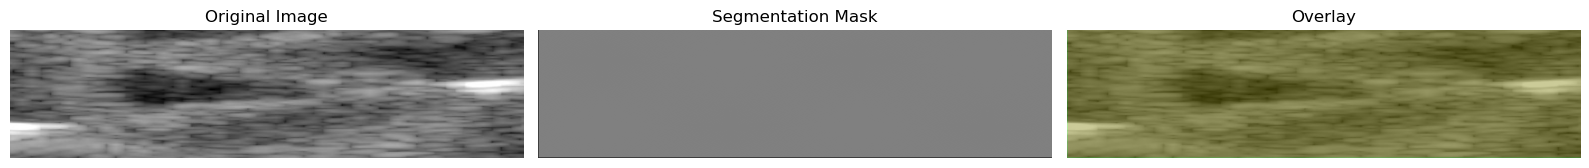

In [3]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# === 1. Load your model ===
model = CNN_C52v()
model.eval()  # Turn off dropout/batchnorm updates

# === 2. Load and preprocess image ===
image_path = "Data/US_Test_2023April7/t3US94_738983_4.jpg"
image = Image.open(image_path).convert('RGB')

# Store original size
original_size = image.size  # (W, H)

# Match model input size
transform = transforms.Compose([
    transforms.Resize((256, 1024)),  # or use original_size[::-1] if your model takes original res
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet-like stats
                         std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)  # [1, 3, H, W]

# === 3. Inference ===
with torch.no_grad():
    output = model(input_tensor)  # [1, 2, H, W]

# === 4. Post-process the output ===

# Get predicted class per pixel
pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()  # shape: (H, W)

# Resize to original resolution for display (if needed)
pred_mask_resized = cv2.resize(pred_mask.astype(np.uint8), original_size, interpolation=cv2.INTER_NEAREST)

# Colorize prediction (optional)
colors = {
    0: [0, 255, 0],   # Green for class 0 (Viable)
    1: [255, 0, 0],   # Red for class 1 (Ablated)
}
color_mask = np.zeros((pred_mask_resized.shape[0], pred_mask_resized.shape[1], 3), dtype=np.uint8)
for cls_id, color in colors.items():
    color_mask[pred_mask_resized == cls_id] = color

# Convert original image to numpy for overlay
image_np = np.array(image.resize(original_size))

# Blend original image with segmentation mask
blended = cv2.addWeighted(image_np, 0.6, color_mask, 0.4, 0)

# === 5. Plot ===
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(pred_mask_resized, cmap='gray')
plt.title("Segmentation Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(blended)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
import onnx
from onnx import numpy_helper

# Load your ONNX model
onnx_model = onnx.load("CNN_C52v_2023March21.onnx")

# Map of tensor name to NumPy array
onnx_weights = {}
for initializer in onnx_model.graph.initializer:
    onnx_weights[initializer.name] = numpy_helper.to_array(initializer)

# Optional: Print all names
print("Extracted ONNX weights:")
for name in onnx_weights:
    print(name, onnx_weights[name].shape)

Extracted ONNX weights:
data_Mean (1, 3, 1, 1)
data_StandardDeviation (1, 3, 1, 1)
conv1_W (64, 3, 7, 7)
conv1_B (64,)
bn_conv1_scale (64,)
bn_conv1_B (64,)
bn_conv1_mean (64,)
bn_conv1_var (64,)
res2a_branch2a_W (64, 64, 3, 3)
res2a_branch2a_B (64,)
bn2a_branch2a_scale (64,)
bn2a_branch2a_B (64,)
bn2a_branch2a_mean (64,)
bn2a_branch2a_var (64,)
res2a_branch2b_W (64, 64, 3, 3)
res2a_branch2b_B (64,)
bn2a_branch2b_scale (64,)
bn2a_branch2b_B (64,)
bn2a_branch2b_mean (64,)
bn2a_branch2b_var (64,)
res2b_branch2a_W (64, 64, 3, 3)
res2b_branch2a_B (64,)
bn2b_branch2a_scale (64,)
bn2b_branch2a_B (64,)
bn2b_branch2a_mean (64,)
bn2b_branch2a_var (64,)
res2b_branch2b_W (64, 64, 3, 3)
res2b_branch2b_B (64,)
bn2b_branch2b_scale (64,)
bn2b_branch2b_B (64,)
bn2b_branch2b_mean (64,)
bn2b_branch2b_var (64,)
res3a_branch2a_W (128, 64, 3, 3)
res3a_branch2a_B (128,)
bn3a_branch2a_scale (128,)
bn3a_branch2a_B (128,)
bn3a_branch2a_mean (128,)
bn3a_branch2a_var (128,)
res3a_branch2b_W (128, 128, 3, 3)
res3

In [8]:
from onnx2pytorch import ConvertModel
import onnx
import torch

# Load the ONNX model
onnx_model = onnx.load("CNN_C52v_2023March21.onnx")
converted_model = ConvertModel(onnx_model)

# Grab its state_dict
converted_state = converted_model.state_dict()

# See keys
print("Keys in ONNX2PyTorch state dict:")
for k in converted_state:
    print(k, converted_state[k].shape)


Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum
Automatic inference of operator: sum
Keys in ONNX2PyTorch state dict:
_initializer_data_Mean torch.Size([1, 3, 1, 1])
_initializer_data_StandardDeviation torch.Size([1, 3, 1, 1])
_initializer_conv1_W torch.Size([64, 3, 7, 7])
_initializer_conv1_B torch.Size([64])
_initializer_bn_conv1_scale torch.Size([64])
_initializer_bn_conv1_B torch.Size([64])
_initializer_bn_conv1_mean torch.Size([64])
_initializer_bn_conv1_var torch.Size([64])
_initializer_res2a_branch2a_W torch.Size([64, 64, 3, 3])
_initializer_res2a_branch2a_B torch.Size([64])
_initializer_bn2a_branch2a_scale torch.Size([64])
_initializer_bn2a_branch2a_B torch.Size([64])
_initializer_bn2a_branch2a_mean torch.Size([64])
_initializer_bn2a_branch2a_var torch.Size([64])
_initia

c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\onnx2pytorch\convert\layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))
